In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import random
import seaborn as sns
sns.set(style="whitegrid")
import collections 
import itertools

## Problem 1.1 - Epidemics over symmetric graphs

You should simulate an epidemic on a symmetric k-regular graph with 500 nodes and k = 4. Let $\beta=3$ and $\rho$=0.7.
With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at random from the node set V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

$\rho$ is the probability that at one time step an infected I individual recovers becoming state R (mutation kernel).

$\beta$ is the probability that a susceptible S becomes and infected I based on the number of infected neighbors.

In [2]:
def draw_k_symmetric(n=8,k=4):
    G = nx.Graph()
    for i in range(n-2):
        G.add_edge(i, i+1)
        G.add_edge(i, i+2)
    G.add_edge(n-2, n-1)
    G.add_edge(n-2, 0)
    G.add_edge(n-1, 0)
    G.add_edge(n-1, 1)
    
    #nx.draw_circular(G, with_labels = True)
    
    return G

G = draw_k_symmetric(500)
print(G)

Graph with 500 nodes and 1000 edges


In [3]:
def simulate_epidemics(graph, n_infected=10, beta=0.3, rho=0.7, n_weeks=15, n_simulation=100,
                      flg_vaccine = False, 
                      vax_campaign = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]):
    
    # S=0, I=1, R=2
    G = graph
    # Number of agents, the number of nodes in the graph
    n_agents = len(G)

    tot_susceptible = np.zeros(n_weeks, dtype=int)
    tot_infected = np.zeros(n_weeks, dtype=int)
    tot_recovered = np.zeros(n_weeks, dtype=int)
    tot_new_infection = np.zeros(n_weeks, dtype=int)
    
    if flg_vaccine == True:
        fract_to_vax = [abs(prev-succ) for prev, succ in zip(vax_campaign, vax_campaign[1:])] + [0]
        tot_vaccinated = np.zeros(n_weeks, dtype=int)
        tot_new_vaccinated = np.zeros(n_weeks, dtype=int)

    for i in range(n_simulation):
        # Initial configuration with random 10 infected nodes
        status = np.zeros(n_agents, dtype=int)
        initial_contagion = random.sample(list(np.arange(n_agents)), n_infected)
        for ix in initial_contagion:
            status[ix] = 1

        susceptible = [n_agents-n_infected]
        infected = [n_infected]
        recovered = [0]
        new_infection = []
        
        if flg_vaccine == True:
            vaccinated = []
            new_vaccination = []         

        curr_state = status.copy()

        for week in range(n_weeks):
            prev_state = curr_state.copy()
            
            if flg_vaccine == True:
                new_vax = 0
                not_vaccinated = np.argwhere(prev_state!=3).squeeze()
                number_to_vax = round(n_agents/100*fract_to_vax[week])
                people_to_vax = np.random.choice(not_vaccinated, size=number_to_vax, replace=False)
                for p in people_to_vax:
                    prev_state[p] = 3
                    new_vax += 1
                new_vaccination.append(new_vax)
                vaccinated.append(len(np.argwhere(prev_state == 3)))
        
            curr_state = prev_state.copy()
            
            new_infect = 0      
            for node in range(n_agents):
                # If the node is susceptible
                if prev_state[node] == 0:
                    # compute the number of infected neighbors
                    neighbors = [i for i in G.neighbors(node)]
                    infect = sum(list(filter(lambda k:k==1, prev_state[neighbors])))
                    # compute the probability of infection
                    prob_infection = 1 - (1-beta)**infect
                    if np.random.rand() < prob_infection:
                        # infected!
                        curr_state[node] = 1
                        new_infect += 1
                # If the node is infected
                elif prev_state[node] == 1:
                    # probability of recover is rho = 0.7
                    if np.random.rand() < rho:
                        # recoved!
                        curr_state[node] = 2
            new_infection.append(new_infect)
            susceptible.append(len(np.argwhere(curr_state == 0)))
            infected.append(len(np.argwhere(curr_state == 1)))
            recovered.append(len(np.argwhere(curr_state == 2)))

        tot_susceptible = [sum(s) for s in zip(tot_susceptible, susceptible)]
        tot_infected = [sum(s) for s in zip(tot_infected, infected)]
        tot_recovered = [sum(s) for s in zip(tot_recovered, recovered)]
        tot_new_infection = [sum(s) for s in zip(tot_new_infection, new_infection)]
        if flg_vaccine == True:
            tot_vaccinated = [sum(s) for s in zip(tot_vaccinated, vaccinated)]
            tot_new_vaccinated = [sum(s) for s in zip(tot_new_vaccinated, new_vaccination)]

    avg_susceptible = [x/n_simulation for x in tot_susceptible]
    avg_infected = [x/n_simulation for x in tot_infected]
    avg_recovered = [x/n_simulation for x in tot_recovered]
    avg_new_infection = [x/n_simulation for x in tot_new_infection]
    if flg_vaccine == True:
        avg_vaccinated = [x/n_simulation for x in tot_vaccinated]
        avg_new_vaccinated = [x/n_simulation for x in tot_new_vaccinated]
        
    if flg_vaccine == True:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection, avg_vaccinated, avg_new_vaccinated
    else:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection

In [4]:
def epidemics_statistics(n_week, avg_susceptible, avg_infected, avg_recovered, avg_new_infection,
                         avg_vaccinated=[],avg_new_vaccinated=[],flg_vaccine = False):

    print("avg susceptible:")
    print(avg_susceptible)
    print("avg infected:")
    print(avg_infected)
    print("avg recovered:")
    print(avg_recovered)
    print("avg new infection:")
    print(avg_new_infection)
    
    if flg_vaccine == True:
        print("avg vaccinated:")
        print(avg_vaccinated)
        print("avg new vaccinated:")
        print(avg_new_vaccinated)
           
    fig, (ax1, ax2)= plt.subplots(2,1,figsize=(15,12))
    x = list(np.arange(15))

    #plt.plot(x, avg_susceptible, label="average susceptible") 
    ax1.plot(x, avg_infected, label="average infected", color = 'red', linewidth=3) 
    ax1.plot(x, avg_recovered, label="average recovered", color = 'green', linewidth=3) 
    ax1.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
             , linewidth=3) 
    if flg_vaccine == True:
        ax2.plot(x, avg_vaccinated, label="average vaccinated", color = 'darkviolet', 
                 linestyle='dashed', linewidth=3)
        ax2.plot(x, avg_new_vaccinated, label="average new vaccinated", color = 'darkorange',
                 linestyle='dashed', linewidth=3)

    ax1.tick_params(axis='x', labelsize=17)
    ax1.tick_params(axis='y', labelsize=17)
    ax1.legend(fontsize=17)

    ax2.plot(x, avg_susceptible, label="average susceptible", color = 'blue', linewidth=3) 
    ax2.tick_params(axis='x', labelsize=17)
    ax2.tick_params(axis='y', labelsize=17)
    ax2.legend(fontsize=17)

    plt.show()

avg susceptible:
[490.0, 478.08, 467.58, 460.21, 454.94, 450.97, 448.13, 446.32, 445.09, 444.18, 443.5, 443.09, 442.85, 442.62, 442.42]
avg infected:
[10.0, 14.84, 14.72, 11.55, 8.64, 6.44, 4.94, 3.17, 2.17, 1.59, 1.19, 0.69, 0.46, 0.37, 0.35]
avg recovered:
[0.0, 7.08, 17.7, 28.24, 36.42, 42.59, 46.93, 50.51, 52.74, 54.23, 55.31, 56.22, 56.69, 57.01, 57.23]
avg new infection:
[11.92, 10.5, 7.37, 5.27, 3.97, 2.84, 1.81, 1.23, 0.91, 0.68, 0.41, 0.24, 0.23, 0.2, 0.13]


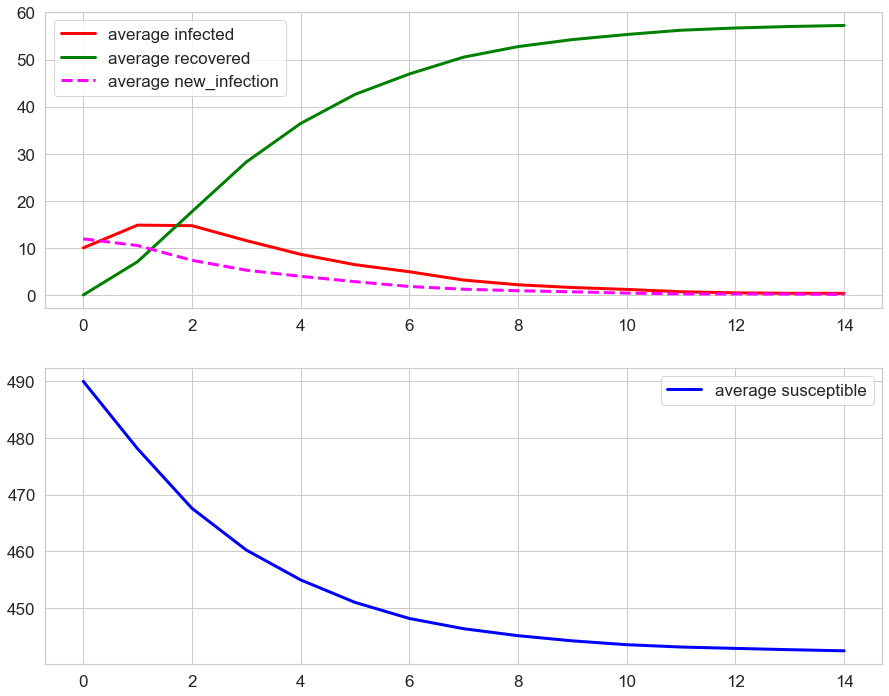

In [5]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 1.2 - Preferential Attachment Random Graph

In [32]:
def create_random_graph(n=40, k=7):
    
    GPA = nx.complete_graph(k+1)
    
    for node in range(k+1, n):
        if k % 2 == 1:
            # if k is uneven take alternatively the floor and ceil of the number
            if node % 2 == 0:
                d = int(np.floor(k/2))
            else:
                d = int(np.ceil(k/2))
        else:
            # k is even
            d = int(k/2)
        
        deg_PA = [d for n, d in GPA.degree()]
        probabilities = np.array(deg_PA)/sum(deg_PA)
        #print(deg_PA)
        # replace=False guarantees no neighbor is chosen twice
        neighbors = np.random.choice(np.arange(len(GPA)), p=probabilities, size=d, replace=False)
        GPA.add_node(node)
        # add the new links 
        for neigh in neighbors:
            GPA.add_edge(node,neigh)   

    #nx.draw_circular(GPA, with_labels = True)
    deg_PA = [d for n, d in GPA.degree()]
    #print()
    #print("number of nodes: ", len(GPA))
    #print("average degree: ", sum(deg_PA)/len(GPA))
    
    return GPA

In [7]:
create_random_graph(910, 7)    

number of nodes:  910
average degree:  7.0


## Problem 2 - Simulate a pandemic without vaccination

In [8]:
G2 = create_random_graph(500, 6)  

number of nodes:  500
average degree:  6.0


avg susceptible:
[490.0, 472.43, 416.36, 312.47, 209.13, 144.77, 113.8, 100.35, 94.32, 92.19, 91.25, 90.84, 90.62, 90.56, 90.55]
avg infected:
[10.0, 20.49, 62.38, 122.64, 139.63, 105.58, 63.08, 32.39, 15.61, 6.87, 3.01, 1.34, 0.59, 0.25, 0.09]
avg recovered:
[0.0, 7.08, 21.26, 64.89, 151.24, 249.65, 323.12, 367.26, 390.07, 400.94, 405.74, 407.82, 408.79, 409.19, 409.36]
avg new infection:
[17.57, 56.07, 103.89, 103.34, 64.36, 30.97, 13.45, 6.03, 2.13, 0.94, 0.41, 0.22, 0.06, 0.01, 0.0]


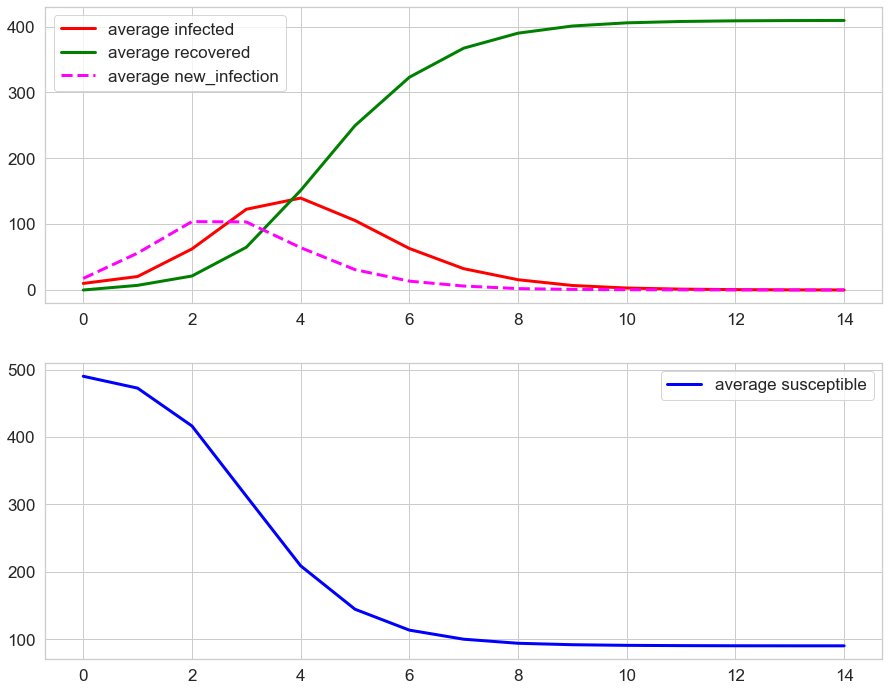

In [9]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G2)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 3 - Simulate a pandemic with vaccination

In [10]:
G3 = create_random_graph(500, 6)  

number of nodes:  500
average degree:  6.0


avg susceptible:
[490.0, 451.16, 363.01, 265.79, 187.57, 137.2, 104.68, 90.51, 89.45, 88.95, 88.73, 88.64, 88.62, 88.58, 88.55]
avg infected:
[10.0, 17.2, 45.32, 66.93, 59.22, 35.8, 16.14, 6.93, 2.92, 1.32, 0.6, 0.29, 0.07, 0.08, 0.04]
avg recovered:
[0.0, 6.64, 16.67, 42.28, 78.21, 102.0, 104.18, 102.56, 107.63, 109.73, 110.67, 111.07, 111.31, 111.34, 111.41]
avg new infection:
[14.41, 40.66, 54.79, 42.61, 21.26, 7.53, 2.71, 1.06, 0.5, 0.22, 0.09, 0.02, 0.04, 0.03, 0.02]
avg vaccinated:
[25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
avg new vaccinated:
[25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


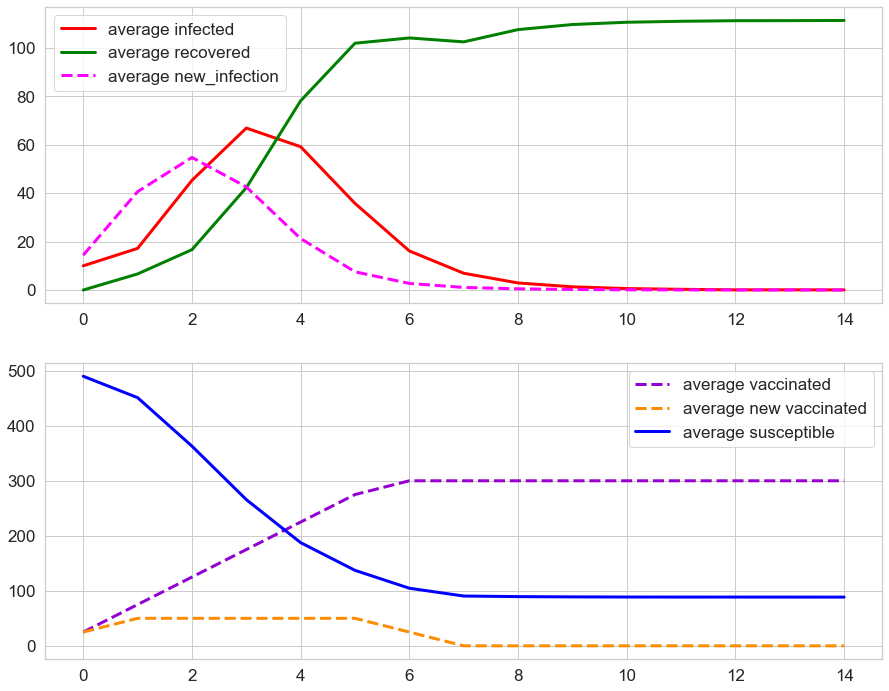

In [11]:
vax_campaign = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
 avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G3,n_infected=10, 
                                                          beta=0.3, rho=0.7, 
                                                          n_weeks=15, n_simulation=100,
                                                          flg_vaccine = True, 
                                                          vax_campaign = vax_campaign)

epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, 
                     avg_new_infection, avg_vaccinated, avg_new_vaccinated, flg_vaccine = True)

## Problem 4 - The H1N1 pandemic in Sweden 2009

In [97]:
k_0 = 10
k_delta = 3
beta_0 = 0.3
beta_delta = 0.1
rho_0 = 0.6
rho_delta = 0.1
n_weeks=15
n_simulation = 10

vax_campaign = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
true_new_infection = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_rmse_k_b_r = (10000000, 10000000, 10000000, 10000000)

stopping_condition = True
#while(stopping_condition):
    
prev_best_rmse_k_b_r = best_rmse_k_b_r

k = np.linspace(1, 5, num=10,  dtype=int) #np.linspace(k_0-k_delta, k_0+k_delta, num=3, dtype = int)  
b = np.linspace(0.1, 0.5, 5) #np.linspace(min(beta_0-beta_delta, beta_delta), beta_0+beta_delta, num=3)
r = np.linspace(0.2, 0.7, 6) #np.linspace(min(rho_0-rho_delta, rho_delta), rho_0+rho_delta, num=3)

combinations = [k, b, r]

# Iterate over all the possible combinations of k, beta e rho
for c in list(itertools.product(*combinations)):

    k_c, b_c, r_c = c

    # generate a random graph
    G = create_random_graph(934, k_c) 

    # simulate epidemics over the random graph
    (avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
     avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G,n_infected=10, 
                                                          beta=b_c, rho=r_c, 
                                                          n_weeks=n_weeks, n_simulation=n_simulation,
                                                          flg_vaccine = True, 
                                                          vax_campaign = vax_campaign)

    print("parameters set: [{}, {}, {}]".format(k_c, b_c, r_c))
    print("avg new infection: ", avg_new_infection)

    # compute RMSE
    sqrt_diff = [(x-y)**2 for x,y in zip(avg_new_infection,true_new_infection)]
    rmse = (sum(sqrt_diff)/n_weeks)**0.5
    print("RMSE = ", rmse)

    # compare with the best RMSE
    if rmse < best_rmse_k_b_r[0]:
        best_rmse_k_b_r = (rmse, k_c, b_c, r_c)

    print()

if (best_rmse_k_b_r[1]==prev_best_rmse_k_b_r[1] and 
    best_rmse_k_b_r[2]==prev_best_rmse_k_b_r[2] and 
    best_rmse_k_b_r[3]==prev_best_rmse_k_b_r[3] ):   
    stopping_condition = False

k_0, beta_0, rho_0 = best_rmse_k_b_r[1], best_rmse_k_b_r[2], best_rmse_k_b_r[3]    

print(best_rmse_k_b_r)

parameters set: [1, 0.1, 0.2]
avg new infection:  [0.5, 0.7, 1.4, 0.4, 0.2, 0.3, 0.4, 0.6, 0.5, 0.2, 0.2, 0.2, 0.1, 0.0, 0.0]
RMSE =  13.326890109849334

parameters set: [1, 0.1, 0.3]
avg new infection:  [0.2, 0.1, 0.1, 0.6, 0.7, 0.4, 0.1, 0.1, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.480677529956225

parameters set: [1, 0.1, 0.4]
avg new infection:  [0.5, 0.3, 0.6, 0.1, 0.3, 0.3, 0.3, 0.2, 0.1, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.45330194908794

parameters set: [1, 0.1, 0.5]
avg new infection:  [0.7, 0.2, 0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.571956380713873

parameters set: [1, 0.1, 0.6]
avg new infection:  [0.2, 0.3, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.58616943807194

parameters set: [1, 0.1, 0.7]
avg new infection:  [0.5, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.59328265480172

parameters set: [1, 0.2, 0.2]
avg new infection:  [1.1, 1.1, 0.7, 0.7, 0.4, 0.2

parameters set: [1, 0.4, 0.7]
avg new infection:  [1.6, 4.3, 6.5, 4.6, 1.3, 0.5, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.424082836454788

parameters set: [1, 0.5, 0.2]
avg new infection:  [1.6, 11.3, 13.8, 11.8, 7.3, 3.9, 1.4, 0.8, 0.4, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.308743992829175

parameters set: [1, 0.5, 0.3]
avg new infection:  [3.0, 6.0, 8.4, 9.5, 7.4, 4.2, 2.2, 0.9, 0.5, 0.2, 0.0, 0.1, 0.1, 0.0, 0.0]
RMSE =  12.649558622075846

parameters set: [1, 0.5, 0.4]
avg new infection:  [1.6, 7.1, 12.9, 12.2, 7.7, 6.5, 2.9, 0.8, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  12.71526641482592

parameters set: [1, 0.5, 0.5]
avg new infection:  [2.1, 2.0, 3.6, 4.7, 4.5, 2.6, 1.0, 0.7, 0.2, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1]
RMSE =  12.866545767998497

parameters set: [1, 0.5, 0.6]
avg new infection:  [2.4, 5.0, 5.7, 4.8, 2.6, 1.0, 0.4, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.310196592587705

parameters set: [1, 0.5, 0.7]
avg new infection:  [2.1, 4.9, 6.1, 4.2, 2

parameters set: [2, 0.30000000000000004, 0.6]
avg new infection:  [3.0, 3.7, 4.3, 1.9, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.496863833251536

parameters set: [2, 0.30000000000000004, 0.7]
avg new infection:  [5.3, 4.8, 5.0, 4.1, 0.7, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.538069778714148

parameters set: [2, 0.4, 0.2]
avg new infection:  [3.5, 8.7, 17.4, 16.2, 11.5, 7.2, 3.5, 1.9, 1.3, 1.4, 0.4, 0.5, 0.3, 0.0, 0.0]
RMSE =  12.86141516319258

parameters set: [2, 0.4, 0.3]
avg new infection:  [3.0, 9.2, 16.2, 11.9, 6.5, 6.2, 4.4, 2.6, 2.2, 0.7, 0.5, 0.5, 0.3, 0.0, 0.0]
RMSE =  12.334828738170629

parameters set: [2, 0.4, 0.4]
avg new infection:  [3.9, 7.0, 9.0, 17.2, 13.9, 5.8, 3.2, 1.0, 0.2, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0]
RMSE =  12.861829833529391

parameters set: [2, 0.4, 0.5]
avg new infection:  [3.2, 8.7, 12.0, 10.0, 5.7, 3.6, 3.5, 2.2, 0.5, 0.4, 0.3, 0.1, 0.1, 0.0, 0.0]
RMSE =  12.537915828929995

parameters set: [2, 0.4, 0.6]
avg ne

parameters set: [3, 0.2, 0.5]
avg new infection:  [1.6, 3.9, 6.1, 5.1, 2.2, 1.3, 0.7, 0.3, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.193230587438899

parameters set: [3, 0.2, 0.6]
avg new infection:  [2.1, 5.4, 6.9, 7.9, 4.1, 1.8, 1.2, 0.9, 0.5, 0.2, 0.1, 0.0, 0.1, 0.0, 0.1]
RMSE =  12.94864214245391

parameters set: [3, 0.2, 0.7]
avg new infection:  [2.1, 6.0, 6.0, 7.6, 4.2, 3.2, 0.9, 0.3, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0]
RMSE =  13.028097840181173

parameters set: [3, 0.30000000000000004, 0.2]
avg new infection:  [2.5, 7.5, 19.9, 28.6, 34.1, 29.2, 16.9, 9.7, 6.4, 4.8, 5.1, 4.2, 4.1, 3.3, 3.1]
RMSE =  13.065935353684658

parameters set: [3, 0.30000000000000004, 0.3]
avg new infection:  [4.8, 7.3, 11.0, 12.8, 12.1, 14.4, 11.7, 10.2, 7.4, 8.5, 6.1, 3.3, 2.8, 2.2, 1.2]
RMSE =  9.030688419679494

parameters set: [3, 0.30000000000000004, 0.4]
avg new infection:  [4.2, 11.1, 18.9, 19.4, 22.2, 17.3, 12.1, 8.6, 5.1, 4.1, 2.7, 2.3, 1.9, 0.8, 1.0]
RMSE =  11.076010111949158

parameters se

parameters set: [4, 0.1, 0.2]
avg new infection:  [1.5, 1.2, 1.2, 1.4, 0.5, 0.2, 0.1, 0.5, 0.6, 0.3, 1.1, 0.4, 0.8, 0.7, 0.2]
RMSE =  13.352228278455998

parameters set: [4, 0.1, 0.3]
avg new infection:  [2.2, 5.0, 6.6, 7.7, 8.2, 4.5, 4.8, 3.4, 2.5, 1.5, 2.0, 1.5, 1.2, 0.9, 0.4]
RMSE =  11.481985890951094

parameters set: [4, 0.1, 0.4]
avg new infection:  [1.7, 2.1, 3.7, 2.0, 1.9, 0.9, 1.0, 1.0, 0.4, 0.4, 0.2, 0.2, 0.1, 0.0, 0.0]
RMSE =  13.021571845723283

parameters set: [4, 0.1, 0.5]
avg new infection:  [1.2, 1.9, 1.2, 1.2, 0.8, 0.4, 0.5, 0.3, 0.1, 0.2, 0.3, 0.6, 0.4, 0.2, 0.0]
RMSE =  13.34258845451911

parameters set: [4, 0.1, 0.6]
avg new infection:  [2.4, 3.3, 2.4, 1.9, 1.3, 0.9, 0.3, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0]
RMSE =  13.357245224970606

parameters set: [4, 0.1, 0.7]
avg new infection:  [1.5, 1.3, 0.8, 0.7, 0.6, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.532282389407438

parameters set: [4, 0.2, 0.2]
avg new infection:  [3.5, 7.7, 13.1, 14.3, 15.5

parameters set: [4, 0.4, 0.5]
avg new infection:  [6.9, 21.4, 40.0, 62.2, 65.0, 46.2, 28.0, 15.6, 8.2, 4.4, 2.9, 2.7, 1.9, 1.0, 0.5]
RMSE =  25.10215130222906

parameters set: [4, 0.4, 0.6]
avg new infection:  [7.2, 24.3, 51.1, 64.1, 57.4, 36.1, 19.0, 9.0, 4.4, 2.3, 1.9, 1.1, 0.4, 0.3, 0.4]
RMSE =  25.767680014571226

parameters set: [4, 0.4, 0.7]
avg new infection:  [7.0, 20.6, 50.4, 62.6, 56.1, 37.1, 17.5, 10.1, 7.5, 4.7, 3.6, 3.0, 1.7, 1.1, 0.3]
RMSE =  25.030714465765186

parameters set: [4, 0.5, 0.2]
avg new infection:  [6.7, 28.5, 77.7, 118.4, 102.6, 67.3, 36.3, 12.9, 7.9, 4.6, 2.2, 2.3, 1.6, 0.8, 0.5]
RMSE =  45.453925389710115

parameters set: [4, 0.5, 0.3]
avg new infection:  [8.2, 30.2, 82.4, 120.6, 105.9, 68.4, 31.3, 15.0, 6.5, 2.4, 1.5, 0.4, 0.2, 0.2, 0.1]
RMSE =  46.9119529899719

parameters set: [4, 0.5, 0.4]
avg new infection:  [10.9, 55.8, 120.3, 131.3, 94.4, 45.0, 18.6, 7.6, 3.1, 1.4, 0.7, 0.7, 0.3, 0.0, 0.0]
RMSE =  52.834426907714885

parameters set: [4, 0.5, 0.5]
av

In [ ]:
k = np.linspace(1, 5, num=5,  dtype=int)
b = np.linspace(0.1, 0.3, num=3)
r = np.linspace(0, 1, num=11)

In [81]:
k_0 = 10
k_delta = 1
beta_0 = 0.3
beta_delta = 0.1
rho_0 = 0.6
rho_delta = 0.1
n_weeks=15
n_simulation = 10

x = np.linspace(beta_0-beta_delta, beta_0+beta_delta, num=3)
x

array([0.2, 0.3, 0.4])

In [94]:
k = np.linspace(1, 10, num=10,  dtype=int)
k

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## Below trash

In [12]:
lis = np.array([1, 1, 3, 2, 2, 3, 2])
print(np.argwhere(lis!=3).squeeze())

[0 1 3 4 6]


In [13]:
print([x for x in lis if x != 3])

[1, 1, 2, 2, 2]


In [14]:
u = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
test = [abs(prev-succ) for prev, succ in zip(u, u[1:])]
print(test)
print(np.random.choice(test, size=4, replace=False))

[5, 10, 10, 10, 10, 10, 5, 0, 0, 0, 0, 0, 0, 0]
[ 0 10 10 10]


In [15]:
x = [10, 2,3]
y = [10, 2,3]
[sum(j) for j in zip(x, y)]

[20, 4, 6]